## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose


# plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("PJME_hourly.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"]).sort_values()
df.set_index("Datetime", inplace=True)
df.sort_index()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


In [3]:
print("Index:     " + str(df.index.dtype))
print(df.dtypes)

Index:     datetime64[ns]
PJME_MW    float64
dtype: object


## Dataset Description

This dataset contains energy consumption data for the East Region, measured in Mega Watts (MW). The dataset consists of a timestamp column and a corresponding column indicating the energy consumption.

### Features:

- **Datetime**: Timestamp indicating the time of energy consumption measurements.
- **PJME_MW**: Energy consumption in Mega Watts (MW) in the East Region.

The dataset provides a time series of energy consumption data, allowing for analysis and exploration of trends and patterns over time.

Mathematically, a forecasting model can be represented as a function $ f(x) $ that maps historical data $ x $ to predicted future values $ \hat{y} $. The general form of a forecasting model can vary depending on the specific problem and the underlying data characteristics.

Here's a basic mathematical representation:

$$\hat{y} = f(x)$$

Where:
-  $\hat{y}$ represents the predicted or forecasted value.
- $ x $ represents the historical data or features used for prediction.
- $ f(\cdot) $ represents the forecasting model, which can be a linear regression, time series analysis, machine learning algorithm, or any other mathematical function tailored to the problem domain.

For example, in linear regression, the forecasting model $ f(x) $ can be represented as:

$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n$$

Where:
- $ \beta_0, \beta_1, \ldots, \beta_n $ are the coefficients or parameters estimated from the historical data $ x $.
- $ x_1, x_2, \ldots, x_n $ are the features or predictors used for forecasting.
- $ \hat{y} $ is the predicted value.

In time series analysis, forecasting models often involve autoregressive integrated moving average (ARIMA), exponential smoothing methods, or machine learning algorithms tailored to time series data. These models capture the temporal dependencies and patterns in the data to make predictions about future values.


## Cleaning and Finding Missing Data

First, let's check if there are any missing dates in the dataset.

In [4]:
missing_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq="H").difference(df.index)
print(len(missing_dates))

30


Before proceeding to interpolate the missing values for the 30 dates, we need to perform a few preliminary steps.

### Interpolating Missing Values in Energy Consumption Data

In this section, we'll explore the presence of missing values in the energy consumption column of our dataset and compare the results obtained if we interpolate these missing values with the results obtained if we leave them as they are.

#### Comparing Results

Finally, we'll compare the final results obtained with interpolating the missing values with the original data to assess the impact of interpolation.

By examining the summary statistics of both the original and interpolated data, we can evaluate the effectiveness of the interpolation method.

#### Checking for Missing Values

Let's start by checking if there are any missing values in the energy consumption column.

In [5]:
df.isna().sum()

PJME_MW    0
dtype: int64

There are no missing values in the energy consumption column, so now we can interpolate the values for the missing dates

In [6]:
complete_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="H")
complete_df = pd.DataFrame(index=complete_index, columns=df.columns)
merged_df = complete_df.merge(df, how="left", left_index=True, right_index=True)

In [7]:
print(merged_df.head())
merged_df["PJME_MW"] = merged_df["PJME_MW_y"]
merged_df.drop(["PJME_MW_x", "PJME_MW_y"], axis=1, inplace=True)

                    PJME_MW_x  PJME_MW_y
2002-01-01 01:00:00       NaN    30393.0
2002-01-01 02:00:00       NaN    29265.0
2002-01-01 03:00:00       NaN    28357.0
2002-01-01 04:00:00       NaN    27899.0
2002-01-01 05:00:00       NaN    28057.0


In [8]:
merged_df.isna().sum()

PJME_MW    30
dtype: int64

These missing values correspond to the dates we previously identified as missing.

In [9]:
merged_df.interpolate(method="linear", inplace=True)
merged_df.isna().sum()

PJME_MW    0
dtype: int64

Now, there are no missing values remaining.

# Using the interpolated dataset

Let's begin by plotting what a typical train/test split should look like and observe how our data behaves.

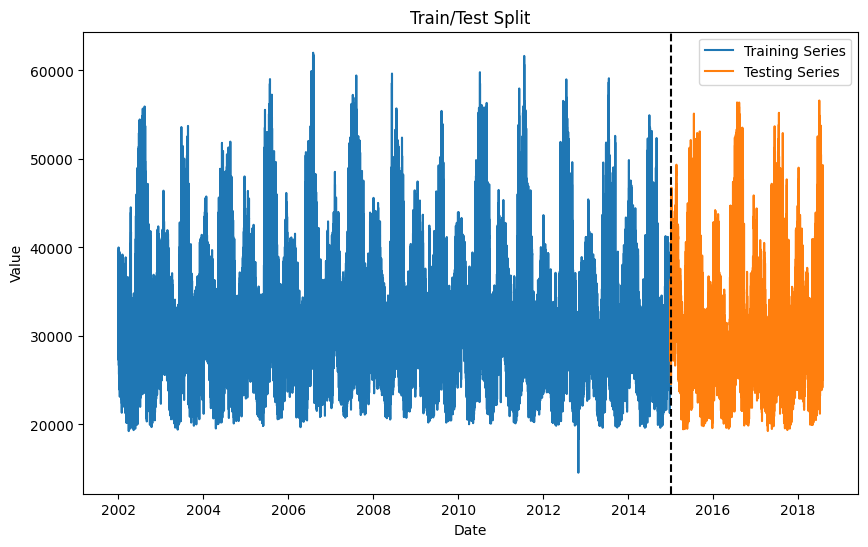

In [10]:
train_merged = merged_df[merged_df.index < "01-01-2015"]
test_merged = merged_df[merged_df.index > "01-01-2015"]

plt.figure(figsize=(10, 6))  # Set the figure size

plt.plot(train_merged.index, train_merged["PJME_MW"], label="Training Series")
plt.plot(test_merged.index, test_merged["PJME_MW"], label="Testing Series")


plt.title("Train/Test Split")
plt.axvline(pd.Timestamp("2015-01-01"), color="black", ls="--")

plt.xlabel("Date")
plt.ylabel("Value")

plt.legend(["Training Series", "Testing Series"])

plt.show()

Here, we can observe that there are also some values between the years 2012 and 2014 that seem a bit out of place and could be considered outliers. Given the significant difference from the other values, we can identify them using graphical techniques

<Axes: ylabel='Frequency'>

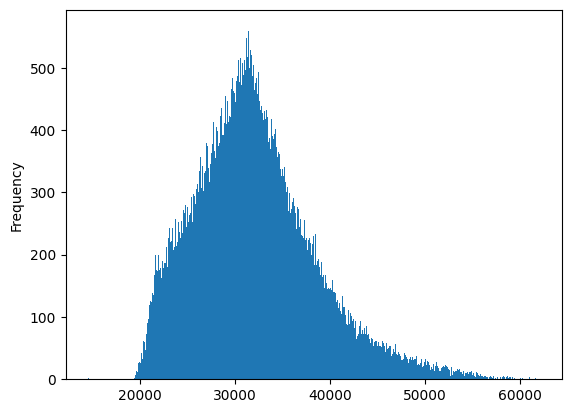

In [11]:
df.plot(kind="hist", bins=1000, legend=False)

We can observe that there are not many values below what appears to be around 19500. However, we can confirm this more accurately in the following plots.

<Axes: xlabel='Datetime'>

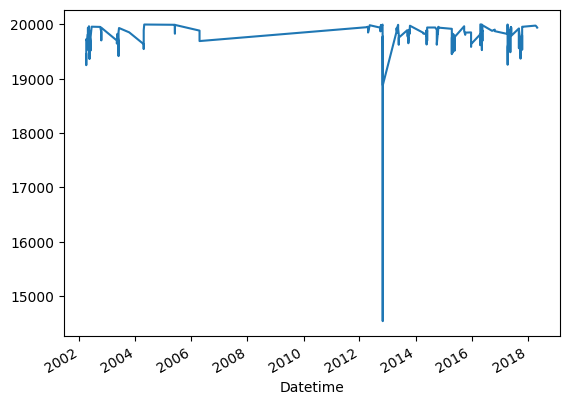

In [12]:
df.query("PJME_MW < 20_000").plot(legend=False)

<Axes: xlabel='Datetime'>

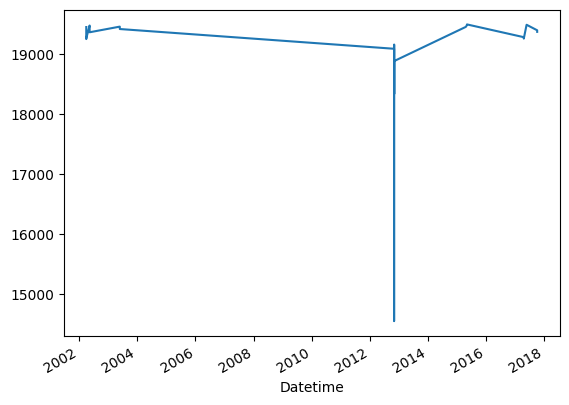

In [13]:
df.query("PJME_MW < 19_500").plot(legend=False)

<Axes: xlabel='Datetime'>

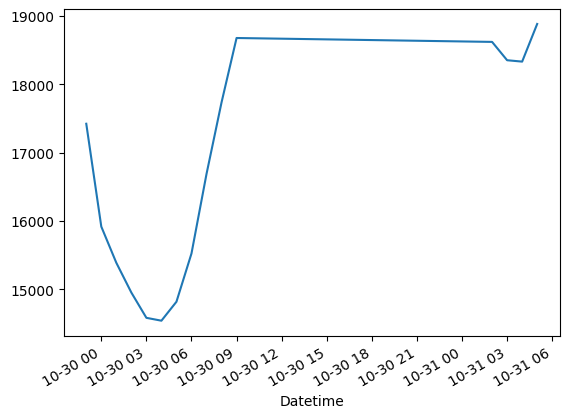

In [14]:
df.query("PJME_MW < 19_000").plot(legend=False)

This value appears to be significantly different from the others and seems to occur only during a short period. It's possible that there was some problem with how these data were recorded during that time. Therefore, we will remove it and interpolate to obtain a new value.

In [15]:
outliers_values = merged_df[merged_df["PJME_MW"] < 19000]
merged_df.loc[outliers_values.index, "PJME_MW"] = np.nan

In [16]:
merged_df["PJME_MW"] = merged_df["PJME_MW"].interpolate(method="linear")
merged_df.isna().sum()

PJME_MW    0
dtype: int64

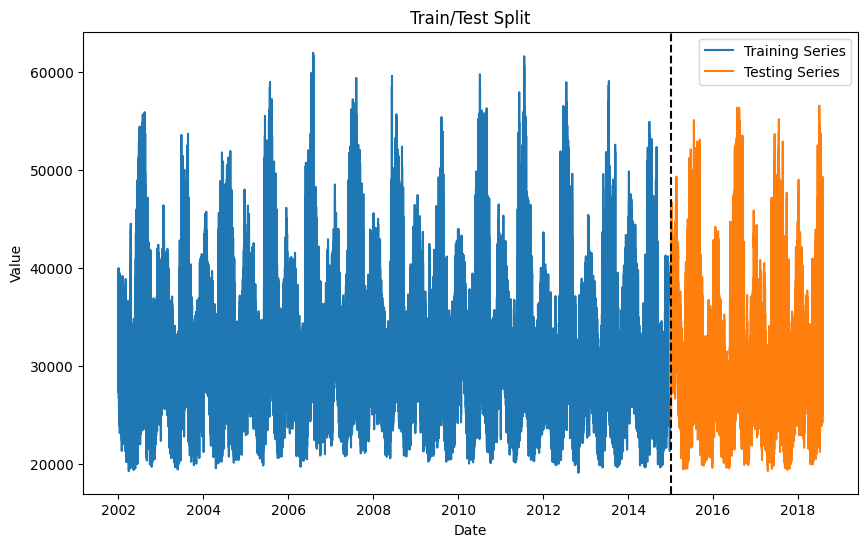

In [17]:
train_merged = merged_df[merged_df.index < "01-01-2015"]
test_merged = merged_df[merged_df.index > "01-01-2015"]

plt.figure(figsize=(10, 6))  # Set the figure size

plt.plot(train_merged.index, train_merged["PJME_MW"], label="Training Series")
plt.plot(test_merged.index, test_merged["PJME_MW"], label="Testing Series")


plt.title("Train/Test Split")
plt.axvline(pd.Timestamp("2015-01-01"), color="black", ls="--")

plt.xlabel("Date")
plt.ylabel("Value")

plt.legend(["Training Series", "Testing Series"])

plt.show()

We can verify that there are no NaN values in our dataset and confirm that the unusual dip around the year 2012 has disappeared.

In [18]:
def create_features(df):    
    df = df.copy()
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["day_of_year"] = df.index.dayofyear
    return df

merged_df = create_features(merged_df)

Text(0, 0.5, 'MW')

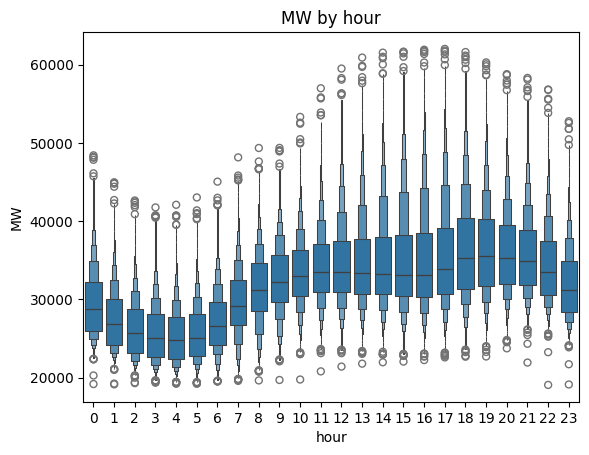

In [19]:
ax = sns.boxenplot(data=merged_df, x="hour", y="PJME_MW", legend=False)
ax.set_title("MW by hour")
ax.set_ylabel("MW")

Text(0, 0.5, 'MW')

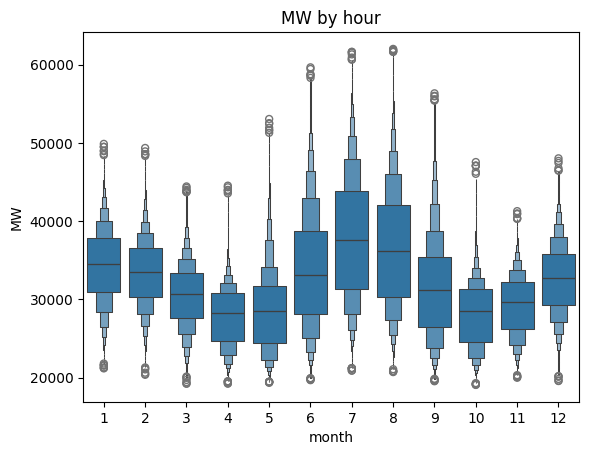

In [20]:
ax = sns.boxenplot(data=merged_df, x="month", y="PJME_MW", legend=False)
ax.set_title("MW by hour")
ax.set_ylabel("MW")

With the values appearing more normal now, we can proceed to start making predictions.

In [21]:
def create_lag(df):
    df = df.copy()
    target_map = df["PJME_MW"].to_dict()

    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("768 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

merged_df = create_lag(merged_df)

We create lag features to provide additional information in our dataset. However, it's important to be cautious about the amount of lag added, ensuring it does not extend beyond the prediction period.

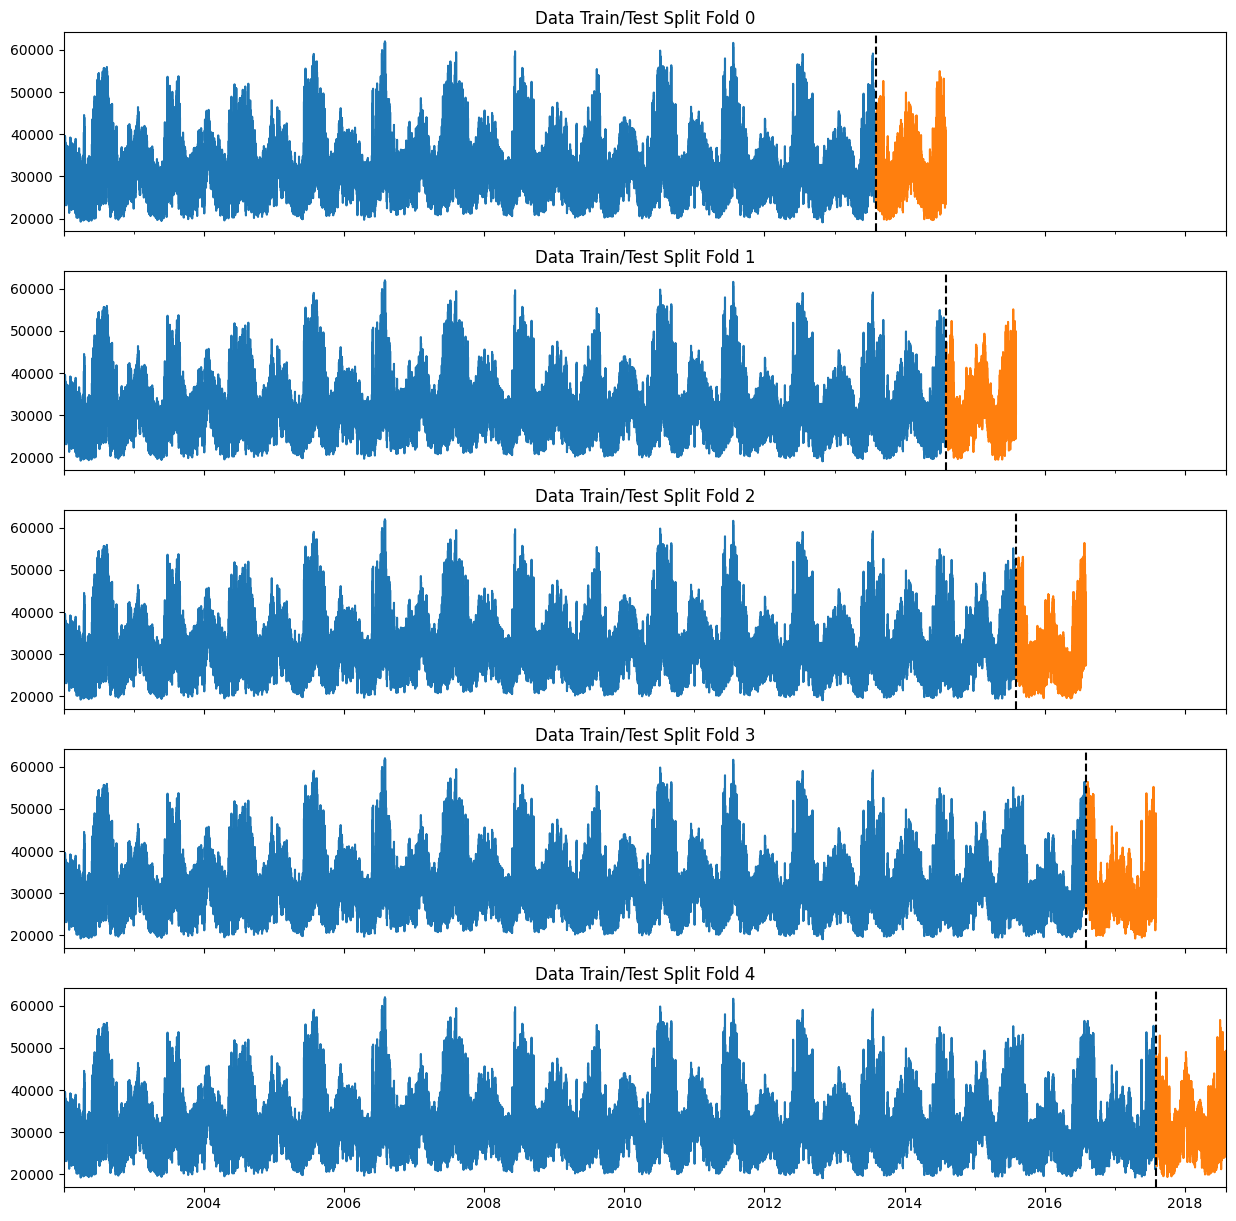

In [22]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
merged_df = merged_df.sort_index()

fig, axs = plt.subplots(5,1, figsize=(15,15), sharex=True)

fold = 0

for train_index, test_index in tss.split(merged_df):
    train = merged_df.iloc[train_index]
    test = merged_df.iloc[test_index]
    
    train["PJME_MW"].plot(ax=axs[fold], 
                          legend=False,
                          title=f"Data Train/Test Split Fold {fold}")
    test["PJME_MW"].plot(ax=axs[fold], legend=False)
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1
    
plt.show()

In [23]:
merged_df

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,lag1,lag2,lag3
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,37421.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,35639.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,34734.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,36490.0,32369.0,34552.0


Now, we can proceed to create our forecasting model using XGBoost and implement cross-validation. Cross-validation is essential because it allows us to assess the performance of our model on multiple subsets of the data. By repeatedly splitting the data into training and validation sets, cross-validation provides a more robust estimate of the model's performance and helps identify potential issues such as overfitting. This ensures that our model's performance is reliable and generalizes well to unseen data.

In [24]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
merged_df = merged_df.sort_index()

fold = 0
preds = []
scores = []
features = ['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year', 'lag1', 'lag2', 'lag3']
target = "PJME_MW"
print(f"Features: {features}")
print(f"Target: {target}")


for train_index, test_index in tss.split(merged_df):
    train = merged_df.iloc[train_index]
    test = merged_df.iloc[test_index]
    
    train = create_features(train)
    test = create_features(test)
    
    x_train = train[features]
    y_train = train[target]
    
    x_test = test[features]
    y_test = test[target]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster="gbtree",
                           n_estimators=2000,
                           early_stopping_rounds = 100,
                           objective="reg:squarederror",
                           max_depth=5,
                           learning_rate=0.01)
    reg.fit(x_train, y_train, 
            eval_set=[(x_train, y_train), (x_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(x_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    fold += 1
    

Features: Index(['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year',
       'lag1', 'lag2', 'lag3'],
      dtype='object')
Target: PJME_MW
[0]	validation_0-rmse:32728.18365	validation_1-rmse:31953.38373
[100]	validation_0-rmse:12450.49201	validation_1-rmse:11863.53828
[200]	validation_0-rmse:5510.11304	validation_1-rmse:5325.70685
[300]	validation_0-rmse:3545.30837	validation_1-rmse:3850.58227
[400]	validation_0-rmse:3090.49207	validation_1-rmse:3731.53896
[500]	validation_0-rmse:2937.01027	validation_1-rmse:3701.00345
[600]	validation_0-rmse:2840.18624	validation_1-rmse:3708.09393
[602]	validation_0-rmse:2838.91857	validation_1-rmse:3707.92342
[0]	validation_0-rmse:32667.90852	validation_1-rmse:32143.96016
[100]	validation_0-rmse:12438.89141	validation_1-rmse:12355.28972
[200]	validation_0-rmse:5530.21666	validation_1-rmse:5684.92985
[300]	validation_0-rmse:3580.98144	validation_1-rmse:3892.56610
[400]	validation_0-rmse:3135.35772	validation_1-rmse:3533.68740
[500]	valid

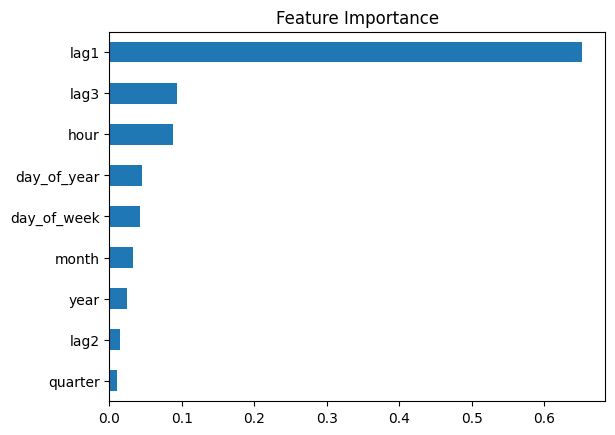

In [25]:
reg_final = pd.DataFrame(data=reg.feature_importances_,
                         index=reg.feature_names_in_,
                         columns=["importance"])

reg_final.sort_values("importance").plot(kind="barh", title="Feature Importance", legend=False)
plt.show()

Here, we can observe the most important features in our model. In this case, the lag features appear to be the two most important features.

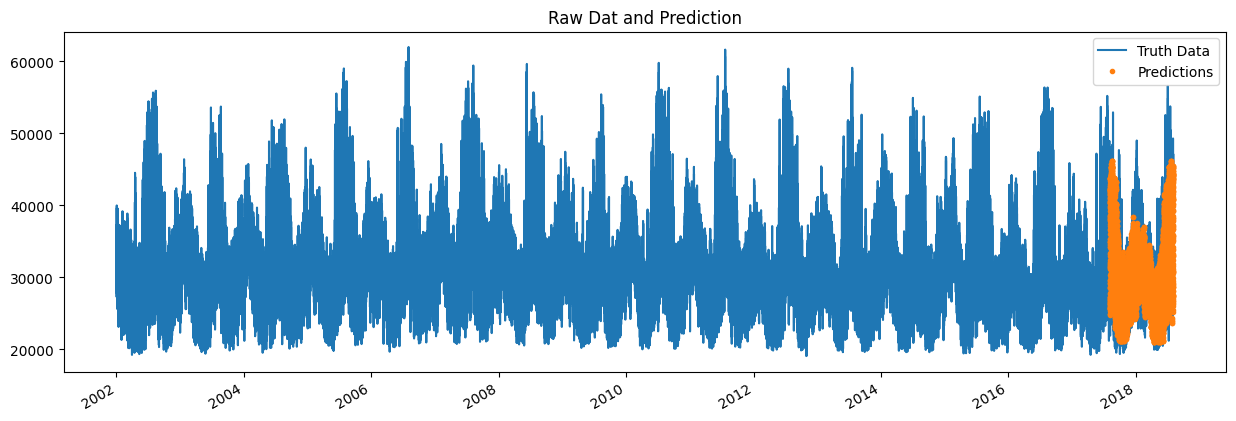

In [26]:
test["prediction"] = reg.predict(x_test)
merged_df = merged_df.merge(test[["prediction"]], how="left", left_index=True, right_index=True)
ax = merged_df[["PJME_MW"]].plot(figsize=(15, 5))
merged_df["prediction"].plot(ax=ax, style=".")
plt.legend(["Truth Data", "Predictions"])
ax.set_title("Raw Data and Predictions")
plt.show()

Here, we can see that the results are not perfect, but their shape is quite accurate.

In [27]:
future_time = pd.date_range("2018-08-03", "2019-08-01", freq="1h")
future_df = pd.DataFrame(index=future_time)
future_df["isFuture"] = True
merged_df["isFuture"] = False
df_and_future = pd.concat([merged_df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = create_lag(df_and_future)

df_and_future.head()

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,lag1,lag2,lag3,prediction,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN,NaN,False


In [28]:
future_w_features = df_and_future.query("isFuture").copy()
future_w_features["pred"] = reg.predict(future_w_features[features])
common_indexes = df_and_future.index.intersection(future_w_features.index)

df_and_future.loc[common_indexes, "PJME_MW"] = future_w_features.loc[common_indexes, "pred"]

<Axes: >

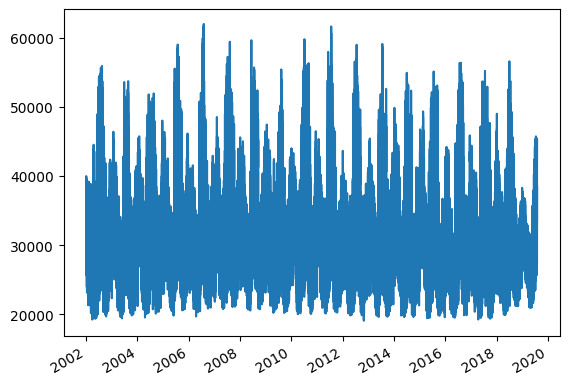

In [29]:
df_and_future["PJME_MW"].plot()

In [30]:
print(f"Score across folds {np.mean(scores):0.4f}")
print(f"Fold Scores: {scores}")

Score across folds 3655.2168
Fold Scores: [3698.2581092395785, 3379.21597665303, 3386.283296230021, 3822.8813758070905, 3989.4454651034366]


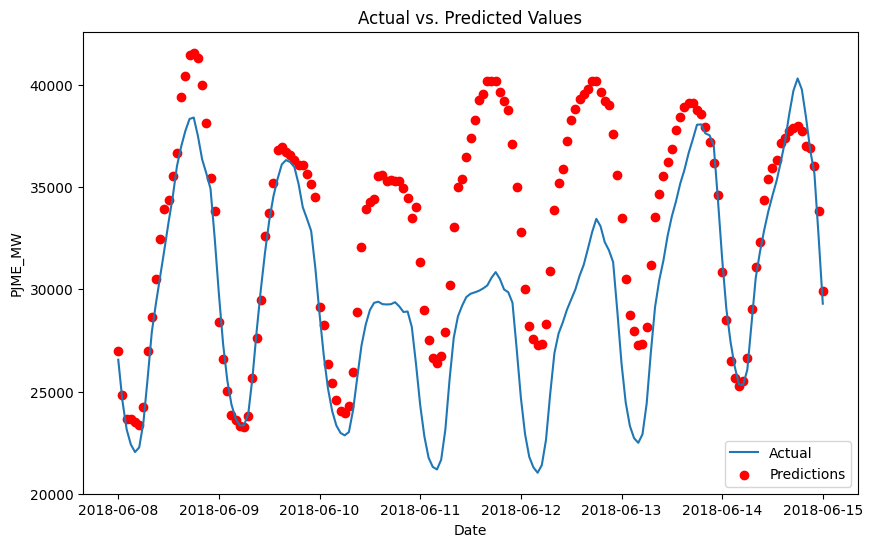

In [43]:
merged_df_filtered = merged_df.dropna(subset=["prediction"])

one_week = merged_df_filtered[(merged_df_filtered.index >= "2018-06-08") & (merged_df_filtered.index <= "2018-06-15")]

plt.figure(figsize=(10, 6))

plt.plot(one_week.index, one_week["PJME_MW"], label="Actual")

plt.scatter(one_week.index, one_week["prediction"], color='red', label="Predictions")

plt.xlabel("Date")
plt.ylabel("PJME_MW")
plt.title("Actual vs. Predicted Values")
plt.legend()

# Show the plot
plt.show()

# Using the original dataset

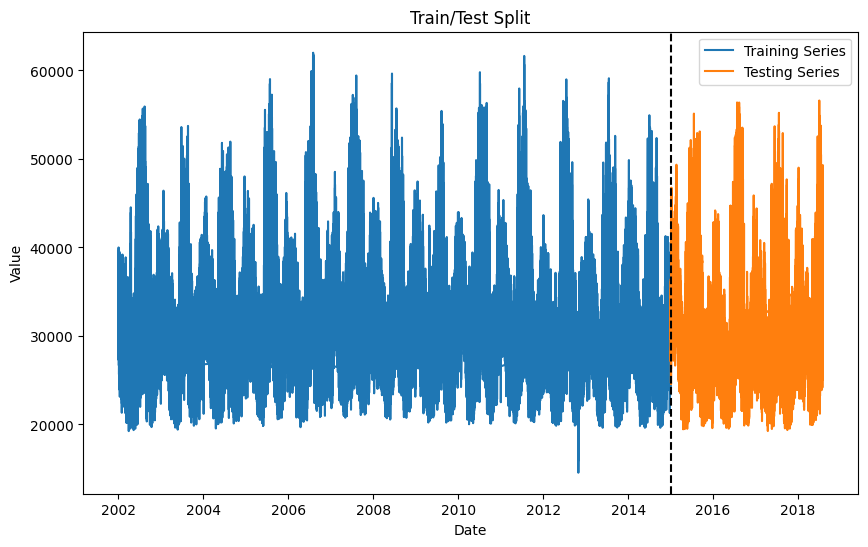

In [33]:
train = df[df.index < "01-01-2015"]
test = df[df.index > "01-01-2015"]

plt.figure(figsize=(10, 6))  # Set the figure size

plt.plot(train.index, train["PJME_MW"], label="Training Series")
plt.plot(test.index, test["PJME_MW"], label="Testing Series")


plt.title("Train/Test Split")
plt.axvline(pd.Timestamp("2015-01-01"), color="black", ls="--")

plt.xlabel("Date")
plt.ylabel("Value")

plt.legend(["Training Series", "Testing Series"])

plt.show()

In [34]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [35]:
def create_features(df):    
    df = df.copy()
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["day_of_year"] = df.index.dayofyear
    return df

In [36]:
df = create_features(df)

def create_lag(df):
    df = df.copy()
    target_map = df["PJME_MW"].to_dict()

    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("768 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

df = create_lag(df)

In [48]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
features = ['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year', 'lag1', 'lag2', 'lag3']
target = "PJME_MW"
print(f"Features: {features}")
print(f"Target: {target}")


for train_index, test_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    
    train = create_features(train)
    test = create_features(test)
    
    x_train = train[features]
    y_train = train[target]
    
    x_test = test[features]
    y_test = test[target]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster="gbtree",
                           n_estimators=2000,
                           early_stopping_rounds = 100,
                           objective="reg:squarederror",
                           max_depth=5,
                           learning_rate=0.01)
    
    reg.fit(x_train, y_train, 
            eval_set=[(x_train, y_train), (x_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(x_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    fold += 1
    

Features: ['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year', 'lag1', 'lag2', 'lag3']
Target: PJME_MW
[0]	validation_0-rmse:32729.92814	validation_1-rmse:31954.26837
[100]	validation_0-rmse:12451.11343	validation_1-rmse:11858.48065
[200]	validation_0-rmse:5511.92400	validation_1-rmse:5320.73969
[300]	validation_0-rmse:3547.04494	validation_1-rmse:3849.17555
[400]	validation_0-rmse:3092.97937	validation_1-rmse:3724.30809
[500]	validation_0-rmse:2936.17697	validation_1-rmse:3696.21142
[579]	validation_0-rmse:2855.25854	validation_1-rmse:3713.67590
[0]	validation_0-rmse:32669.73162	validation_1-rmse:32141.65337
[100]	validation_0-rmse:12439.92001	validation_1-rmse:12350.42956
[200]	validation_0-rmse:5532.39813	validation_1-rmse:5678.58763
[300]	validation_0-rmse:3584.53994	validation_1-rmse:3892.27439
[400]	validation_0-rmse:3138.35828	validation_1-rmse:3533.76777
[500]	validation_0-rmse:2987.30461	validation_1-rmse:3428.54186
[600]	validation_0-rmse:2907.03534	validation_1

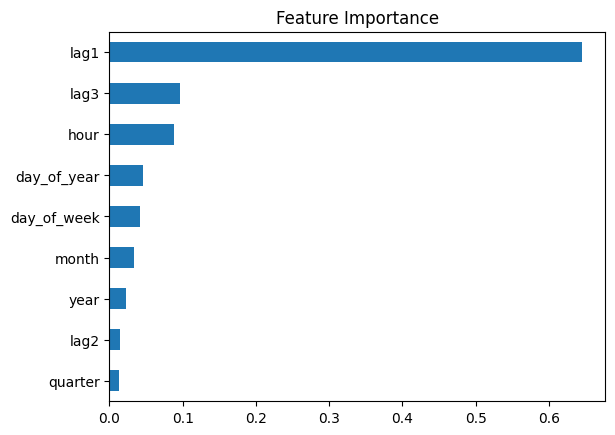

In [49]:
reg_final = pd.DataFrame(data=reg.feature_importances_,
                         index=reg.feature_names_in_,
                         columns=["importance"])

reg_final.sort_values("importance").plot(kind="barh", title="Feature Importance", legend=False)
plt.show()

In [50]:
print(f"Score across folds {np.mean(scores):0.4f}")
print(f"Fold Scores: {scores}")

Score across folds 3652.7420
Fold Scores: [3689.6479120342033, 3375.502487672871, 3395.236542079977, 3821.129807056993, 3982.193060424055]


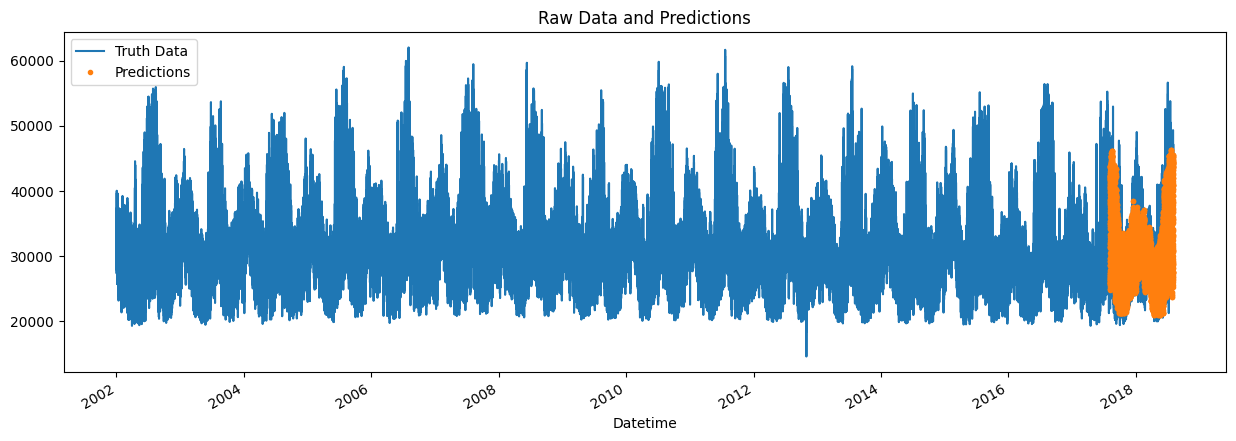

In [55]:
test["prediction"] = reg.predict(x_test)
df = df.merge(test[["prediction"]], how="left", left_index=True, right_index=True)
ax = df[["PJME_MW"]].plot(figsize=(15, 5))
merged_df["prediction"].plot(ax=ax, style=".")
plt.legend(["Truth Data", "Predictions"])
ax.set_title("Raw Data and Predictions")
plt.show()

In [56]:
future_time = pd.date_range("2018-08-03", "2019-08-01", freq="1h")
future_df = pd.DataFrame(index=future_time)
future_df["isFuture"] = True
df["isFuture"] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = create_lag(df_and_future)
df_and_future.head()

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,lag1,lag2,lag3,isFuture,prediction
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN,False,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN,False,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN,False,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN,False,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN,False,NaN


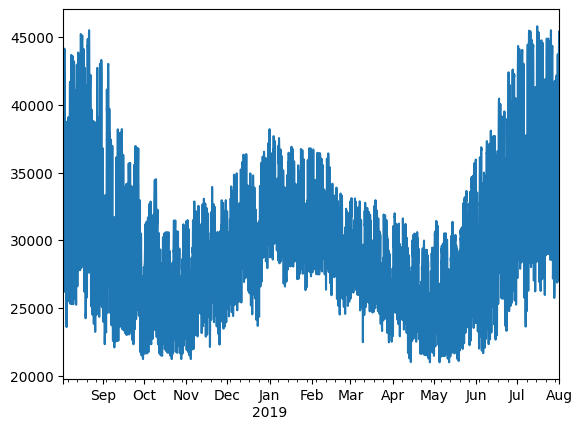

In [57]:
feature_w_features = df_and_future.query("isFuture").copy()

feature_w_features["pred"] = reg.predict(feature_w_features[features])

feature_w_features["pred"].plot()
plt.show()

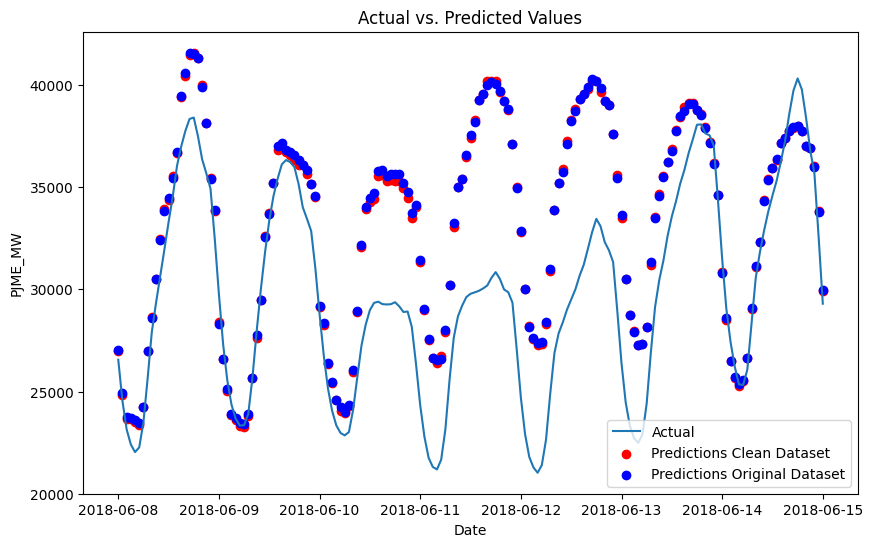

In [59]:
merged_df_filtered = merged_df.dropna(subset=["prediction"])
df_filtered = df.dropna(subset=["prediction"])

one_week_merged = merged_df_filtered[(merged_df_filtered.index >= "2018-06-08") & (merged_df_filtered.index <= "2018-06-15")]
one_week = df_filtered[(merged_df_filtered.index >= "2018-06-08") & (merged_df_filtered.index <= "2018-06-15")]

plt.figure(figsize=(10, 6))

plt.plot(one_week_merged.index, one_week_merged["PJME_MW"], label="Actual")

plt.scatter(one_week_merged.index, one_week_merged["prediction"], color='red', label="Predictions Clean Dataset")

plt.scatter(one_week.index, one_week["prediction"], color='blue', label="Predictions Original Dataset")

plt.xlabel("Date")
plt.ylabel("PJME_MW")
plt.title("Actual vs. Predicted Values")
plt.legend()

# Show the plot
plt.show()

After analyzing the results, it appears that despite making changes to the dataset, such as adding and modifying certain values, the overall outcome remains largely unchanged. While some minor differences were observed, the overall trends and patterns remain consistent. This suggests that the changes made may not have had a substantial impact on the final predictions or conclusions drawn from the analysis. Further investigation may be warranted to determine the exact reasons for the observed similarities and differences. Nonetheless, these findings underscore the robustness of the predictive model and the stability of the insights derived from the data.